# Your First DataJoint Pipeline

This tutorial introduces DataJoint by building a simple research lab database. You'll learn to:

- Define tables with primary keys and dependencies
- Insert and query data
- Use the four core operations: restriction, projection, join, aggregation
- Understand the schema diagram

We'll work with **Manual tables** only—tables where you enter data directly. Later tutorials introduce automated computation.

For complete working examples, see:
- [University Database](../examples/university.ipynb) — Academic records with complex queries
- [Blob Detection](../examples/blob-detection.ipynb) — Image processing with computation

## Setup

In [1]:
import datajoint as dj

schema = dj.Schema('tutorial_first_pipeline')

[2026-01-11 12:29:24,961][INFO]: DataJoint 2.0.0a16 connected to root@127.0.0.1:3306


## The Domain: A Research Lab

We'll model a research lab that:
- Has **researchers** who conduct experiments
- Works with **subjects** (e.g., mice)
- Runs **sessions** where data is collected
- Collects **recordings** during each session

The workflow flows naturally:
```
Researcher    Subject
     \         /
      Session
         |
     Recording
```

## Defining Tables

Each table is a Python class. The `definition` string specifies:
- **Primary key** (above `---`) — uniquely identifies each row
- **Attributes** (below `---`) — additional data for each row
- **Dependencies** (`->`) — references to other tables

In [2]:
@schema
class Researcher(dj.Manual):
    definition = """
    researcher_id : int32
    ---
    researcher_name : varchar(100)
    email : varchar(100)
    """

In [3]:
@schema
class Subject(dj.Manual):
    definition = """
    subject_id : int32
    ---
    species : varchar(32)
    date_of_birth : date
    sex : enum('M', 'F', 'unknown')
    """

### Dependencies

A `Session` involves one researcher and one subject. The `->` syntax creates a **dependency** (foreign key):

In [4]:
@schema
class Session(dj.Manual):
    definition = """
    -> Subject
    session_date : date
    ---
    -> Researcher
    session_notes : varchar(255)
    """

The `-> Subject` in the primary key means:
- `subject_id` is automatically included in Session's primary key
- Combined with `session_date`, each session is uniquely identified
- You cannot create a session for a non-existent subject

The `-> Researcher` below the line is a non-primary dependency—it records who ran the session but isn't part of the unique identifier.

In [5]:
@schema
class Recording(dj.Manual):
    definition = """
    -> Session
    recording_id : int16
    ---
    duration : float32          # recording duration (seconds)
    quality : enum('good', 'fair', 'poor')
    """

## Schema Diagram

The diagram shows tables and their dependencies:

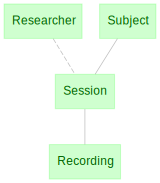

In [6]:
dj.Diagram(schema)

**Reading the diagram:**
- **Green boxes** = Manual tables (you enter data)
- **Solid lines** = Primary key dependencies (part of identity)
- **Dashed lines** = Non-primary dependencies (references)

## Inserting Data

Data must be inserted in dependency order—you can't reference something that doesn't exist.

In [7]:
# First: tables with no dependencies
Researcher.insert([
    {'researcher_id': 1, 'researcher_name': 'Alice Chen', 'email': 'alice@lab.org'},
    {'researcher_id': 2, 'researcher_name': 'Bob Smith', 'email': 'bob@lab.org'},
])

Subject.insert([
    {'subject_id': 1, 'species': 'mouse', 'date_of_birth': '2024-01-15', 'sex': 'M'},
    {'subject_id': 2, 'species': 'mouse', 'date_of_birth': '2024-01-20', 'sex': 'F'},
    {'subject_id': 3, 'species': 'mouse', 'date_of_birth': '2024-02-01', 'sex': 'M'},
])

In [8]:
# Then: tables that depend on others
Session.insert([
    {'subject_id': 1, 'session_date': '2024-06-01', 'researcher_id': 1, 'session_notes': 'First session'},
    {'subject_id': 1, 'session_date': '2024-06-15', 'researcher_id': 1, 'session_notes': 'Follow-up'},
    {'subject_id': 2, 'session_date': '2024-06-10', 'researcher_id': 2, 'session_notes': 'Initial recording'},
])

In [9]:
# Finally: tables at the bottom of the hierarchy
Recording.insert([
    {'subject_id': 1, 'session_date': '2024-06-01', 'recording_id': 1, 'duration': 300.5, 'quality': 'good'},
    {'subject_id': 1, 'session_date': '2024-06-01', 'recording_id': 2, 'duration': 450.0, 'quality': 'good'},
    {'subject_id': 1, 'session_date': '2024-06-15', 'recording_id': 1, 'duration': 600.0, 'quality': 'fair'},
    {'subject_id': 2, 'session_date': '2024-06-10', 'recording_id': 1, 'duration': 350.0, 'quality': 'good'},
])

## Viewing Data

Display a table by calling it:

In [10]:
Subject()

subject_id,species,date_of_birth,sex
1,mouse,2024-01-15,M
2,mouse,2024-01-20,F
3,mouse,2024-02-01,M


In [11]:
Recording()

subject_id,session_date,recording_id,duration recording duration (seconds),quality
1,2024-06-01,1,300.5,good
1,2024-06-01,2,450.0,good
1,2024-06-15,1,600.0,fair
2,2024-06-10,1,350.0,good


## The Four Core Operations

DataJoint queries use four fundamental operations. These compose to answer any question about your data.

### 1. Restriction (`&`) — Filter rows

Keep only rows matching a condition:

In [12]:
# Subjects that are male
Subject & {'sex': 'M'}

subject_id,species,date_of_birth,sex
1,mouse,2024-01-15,M
3,mouse,2024-02-01,M


In [13]:
# Recordings with good quality
Recording & 'quality = "good"'

subject_id,session_date,recording_id,duration recording duration (seconds),quality
1,2024-06-01,1,300.5,good
1,2024-06-01,2,450.0,good
2,2024-06-10,1,350.0,good


In [14]:
# Sessions for subject 1
Session & {'subject_id': 1}

subject_id,session_date,researcher_id,session_notes
1,2024-06-01,1,First session
1,2024-06-15,1,Follow-up


### 2. Projection (`.proj()`) — Select columns

Choose which attributes to return, or compute new ones:

In [15]:
# Just names and emails
Researcher.proj('researcher_name', 'email')

researcher_id,researcher_name,email
1,Alice Chen,alice@lab.org
2,Bob Smith,bob@lab.org


In [16]:
# Compute duration in minutes
Recording.proj(duration_min='duration / 60')

subject_id,session_date,recording_id,duration_min calculated attribute
1,2024-06-01,1,5.008333333333334
1,2024-06-01,2,7.5
1,2024-06-15,1,10.0
2,2024-06-10,1,5.833333333333333


### 3. Join (`*`) — Combine tables

Merge data from related tables:

In [17]:
# Sessions with subject info
Session * Subject

subject_id,session_date,researcher_id,session_notes,species,date_of_birth,sex
1,2024-06-01,1,First session,mouse,2024-01-15,M
1,2024-06-15,1,Follow-up,mouse,2024-01-15,M
2,2024-06-10,2,Initial recording,mouse,2024-01-20,F


In [18]:
# Full recording details with subject and researcher
(Recording * Session * Subject * Researcher).proj(
    'researcher_name', 'species', 'duration', 'quality'
)

subject_id,session_date,recording_id,duration recording duration (seconds),quality,species,researcher_name
1,2024-06-01,1,300.5,good,mouse,Alice Chen
1,2024-06-01,2,450.0,good,mouse,Alice Chen
1,2024-06-15,1,600.0,fair,mouse,Alice Chen
2,2024-06-10,1,350.0,good,mouse,Bob Smith


### 4. Aggregation (`.aggr()`) — Summarize groups

Compute statistics across groups of rows:

In [19]:
# Count recordings per session
Session.aggr(Recording, num_recordings='count(*)')

subject_id,session_date,num_recordings calculated attribute
1,2024-06-01,2
1,2024-06-15,1
2,2024-06-10,1


In [20]:
# Total recording time per subject
Subject.aggr(Recording, total_duration='sum(duration)')

subject_id,total_duration calculated attribute
1,1350.5
2,350.0
3,None


In [21]:
# Average duration across all recordings
dj.U().aggr(Recording, avg_duration='avg(duration)')

avg_duration calculated attribute
425.125


## Combining Operations

Operations chain together to answer complex questions:

In [22]:
# Good-quality recordings for male subjects, with researcher name
(
    Recording 
    & 'quality = "good"' 
    & (Subject & {'sex': 'M'})
) * Session * Researcher.proj('researcher_name')

subject_id,session_date,recording_id,duration recording duration (seconds),quality,researcher_id,session_notes,researcher_name
1,2024-06-01,1,300.5,good,1,First session,Alice Chen
1,2024-06-01,2,450.0,good,1,First session,Alice Chen


In [23]:
# Count of good recordings per researcher
Researcher.aggr(
    Session * (Recording & 'quality = "good"'),
    good_recordings='count(*)'
)

researcher_id,good_recordings calculated attribute
1,2
2,1


## Fetching Data

To get data into Python, use fetch methods:

In [24]:
# Fetch as list of dicts
Subject.to_dicts()

[{'subject_id': 1,
  'species': 'mouse',
  'date_of_birth': datetime.date(2024, 1, 15),
  'sex': 'M'},
 {'subject_id': 2,
  'species': 'mouse',
  'date_of_birth': datetime.date(2024, 1, 20),
  'sex': 'F'},
 {'subject_id': 3,
  'species': 'mouse',
  'date_of_birth': datetime.date(2024, 2, 1),
  'sex': 'M'}]

In [25]:
# Fetch specific attributes as arrays
durations = (Recording & 'quality = "good"').to_arrays('duration')
print(f"Good recording durations: {durations}")

Good recording durations: [300.5 450.  350. ]


In [26]:
# Fetch one row
one_subject = (Subject & {'subject_id': 1}).fetch1()
print(f"Subject 1: {one_subject}")

Subject 1: {'subject_id': 1, 'species': 'mouse', 'date_of_birth': datetime.date(2024, 1, 15), 'sex': 'M'}


## Deleting Data

Deleting respects dependencies—downstream data is deleted automatically:

In [27]:
# This would delete the session AND all its recordings
# (Session & {'subject_id': 2, 'session_date': '2024-06-10'}).delete()

# Uncomment to try (will prompt for confirmation)

## Summary

You've learned the fundamentals of DataJoint:

| Concept | Description |
|---------|-------------|
| **Tables** | Python classes with a `definition` string |
| **Primary key** | Above `---`, uniquely identifies rows |
| **Dependencies** | `->` creates foreign keys |
| **Restriction** | `&` filters rows |
| **Projection** | `.proj()` selects/computes columns |
| **Join** | `*` combines tables |
| **Aggregation** | `.aggr()` summarizes groups |

### Next Steps

- [Schema Design](02-schema-design.ipynb) — Primary keys, relationships, table tiers
- [Queries](04-queries.ipynb) — Advanced query patterns
- [Computation](05-computation.ipynb) — Automated processing with Imported/Computed tables

### Complete Examples

- [University Database](../examples/university.ipynb) — Complex queries on academic records
- [Blob Detection](../examples/blob-detection.ipynb) — Image processing pipeline with computation

In [28]:
# Cleanup
schema.drop(prompt=False)